<a href="https://colab.research.google.com/github/GMdSilva/af2_subsampling_opt/blob/main/angra_porb_mutants.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Install dependencies
%%time
import os
from zipfile import ZipFile
from google.colab import files
!pip install git+https://github.com/GMdSilva/af2_subsampling_opt

  Cloning https://github.com/GMdSilva/af2_subsampling_opt to /tmp/pip-req-build-hlhogjcq
  Running command git clone --filter=blob:none --quiet https://github.com/GMdSilva/af2_subsampling_opt /tmp/pip-req-build-hlhogjcq
  Resolved https://github.com/GMdSilva/af2_subsampling_opt to commit 44183aa1124951d98b80be2a413aef653b7fcc93
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 35.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 4.6 MB/s eta 0:00:00
  Created wheel for angra: filename=angra-0.1-py3-none-any.whl size=43159 sha256=2a0df614f3d780844db4a4a79d81d35b50f44081d8b5e1efdb8ca0ec02f86e8c
  Stored in directory: /tmp/pip-ephem-wheel-cache-hr269klc/wheels/2c/10/3d/63e62e0eac669b32d4917c2dee0a134bb7a91c74c40499bb23
Successfully built angra
CPU times: user

In [2]:
#@title ### **To run demo, click  "Run All" or CTRL+F9**
#@markdown ### User-Controlled Parameters

#@markdown ---
#@markdown ### Demo Data
#@markdown Use demo data (overrides other parameters if checked):
use_demo_data = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### AF2 Predictions
#@markdown Jobname for AF2 predictions:
af2_jobname = "porb_wt" #@param {type:"string"}

# #@markdown Reindex AF2 predictions (starting from index 1)?
# reindex = True #@param {type:"boolean"}

# #@markdown New index for first residue (active if reindex is selected):
# first_residue_index = 229 #@param {type:"raw"}

#@markdown ---
#@markdown ### Subsampling for Ensemble Prediction
#@markdown Test various subsampling parameters (requires different subsampling parameters in AF2 predictions):
optimize_subsampling = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### Mutant Analysis
#@markdown Evaluate the effect of mutants on relative state populations (requires AF2 predictions for each mutant):
test_mutants = True #@param {type:"boolean"}

#@markdown ---
#@markdown ### Benchmarking Mode
#@markdown Assess accuracy of mutant vs. wildtype predictions (requires knowledge of mutation effects on state populations):
benchmarking_mode = True #@param {type:"boolean"}


In [3]:
#@title **Define user-controlled parameters, leave as is for demo data**
#@markdown ### User-Controlled Parameters

#@markdown ---
#@markdown **Subsampling for Ensemble Prediction**

if optimize_subsampling:
  #@markdown Enter comma-separated parameter pairs in the format 'maxseq_extraseq' for AF2 predictions:
  try:
    subsampling_pairs = ['16_32', '32_64', '64_128', '128_256', '256_512', '512_1024', '1024_2048', '2048_4096'] #@param {type:"raw"}
  except TypeError:
      print("Must be a comma-separated list of parameters in format 'maxseq_extraseq'.")

#@markdown ---
#@markdown **Mutant Analysis**

if test_mutants:
  #@markdown Enter filename prefixes for the variants (including wild-type) to be analyzed:
  filenames = ['porb_wt', 'porb_d122n', 'porb_s312e', 'porb_e318n'] #@param {type:"raw"}

  #@markdown Labels for the variants (used for plotting). Ensure the ordering matches with filenames:
  labels = ['PORB', 'PORB D122N', 'PORB S312E', 'PORB E318N'] #@param {type:"raw"}

  #@markdown Order to organize results in plots. Ensure the ordering matches with filenames:
  order = ['4', '3', '2', '1', '0'] #@param {type:"raw"}

#@markdown ---
#@markdown **Benchmarking Mode**

  if benchmarking_mode:
    #@markdown If known, specify effects of variants in the ground or alt state populations. Use "ref" for wild-type/reference, "-" for decrease, and "+" for increase. Ensure the ordering matches with filenames:

    ground_pop_effects = ['ref', '+', '+', '+', '+'] #@param {type:"raw"}
    alt_pop_effects = ['ref', '-', '-', '-', '-'] #@param {type:"raw"}
  else:
    ground_pop_effects = ['ref', 'ref', 'ref', 'ref', 'ref']
    alt_pop_effects = ['ref', 'ref', 'ref', 'ref', 'ref']

  mutant_dict = {}
  for filename, label, order, ground_pop_effect, alt_pop_effect in zip(filenames, labels, order, ground_pop_effects, alt_pop_effects):
    mutant_dict[filename] = {'label': label, "effect": {"ground_pop": ground_pop_effect, 'alt1_pop': alt_pop_effect}, 'rank': order}


In [4]:
print("Creating directories")
from user_settings.config import build_configs_dict, update_config
from angra.utilities.utilities import delete_all_analysis
import shutil
#@title **Create directories and update configurations**
try:
  shutil.rmtree(f"{af2_jobname}_angra_pred")
except:
  pass
os.mkdir(f"{af2_jobname}_angra_pred")
os.chdir(f"{af2_jobname}_angra_pred")
!mkdir results
!mkdir results/plots
!mkdir results/optimization_results
!mkdir results/optimization_results/peaks
!mkdir results/reports
!mkdir results/misc_data
!mkdir results/mutant_analysis
!mkdir results/references
################################################################################
print('Updating configurations with user-supplied values')
configs_dict = build_configs_dict()
configs_dict['SYSTEM_NAME'] = af2_jobname
configs_dict['MUTANT_DATA'] = mutant_dict
# configs_dict['REINDEX'] = reindex
# configs_dict['FIRST_RESIDUE'] = first_residue_index
configs_dict['IS_JUPYTER'] = True
configs_dict['PREDICTION_ROOT'] = f'/content/{af2_jobname}_angra_pred'
update_config(configs_dict)
print("Finished!")


Creating directories
Updating configurations with user-supplied values
Finished!


In [5]:
# @title **Run cell to download demo data or upload own predictions**

if use_demo_data:
  print("Fetching demo data")
  !git clone https://github.com/GMdSilva/porb_predictions_selected
  !mv porb_predictions_selected/ results/af2_predictions
  print("Finished fetching data")

if not use_demo_data:
# @markdown If not running demo:

# @markdown Please upload a `.zip` folder containing all the AF2 prediction outputs you wish to analyze.

# @markdown **Structure of the zipped folder:**
# @markdown - Within the uploaded zipped folder, the content should be organized as:
# @markdown    - `[af2_jobname]_[max_seq[i]]_[extra_seq[i]]/` for each max_seq:extra_seq pair
# @markdown       - For example:
# @markdown           - `abl_wt_256_512/`
# @markdown           - `abl_wt_512_1024/`
# @markdown           - ... and so on.
# @markdown - For each max_seq:extra_seq subsampling pair.

# @markdown **If Analyzing Mutants:**
# @markdown - Include them in the zipped folder
# @markdown - Naming convention for mutant predictions should follow:
# @markdown    - `[mutant_prefix]_[opt_max_seq]_[opt_extra_seq]/`
# @markdown       - For example:
# @markdown           - `abl_F382L_256_512/`
# @markdown           - `abl_F382V_256_512/`
# @markdown           - ... and so on.
# @markdown    - Where:
# @markdown        - `opt_max_seq` and `opt_extra_seq` are the optimized subsampling parameters.

  print("Upload prediction data.")
  af2_predictions = files.upload()
  with ZipFile(list(af2_predictions.keys())[0], 'r') as zip:
    zip.extractall(path='results/af2_predictions')
  print("Finished uploading data")

Fetching demo data
Cloning into 'porb_predictions_selected'...
remote: Enumerating objects: 3598, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 3598 (delta 0), reused 3 (delta 0), pack-reused 3595
Receiving objects: 100% (3598/3598), 429.56 MiB | 15.91 MiB/s, done.
Resolving deltas: 100% (1639/1639), done.
Updating files: 100% (3620/3620), done.
Finished fetching data


In [6]:
# @title **Identify regions of high variance within each WT prediction**
from angra.workflow import *
from user_settings.config import SYSTEM_NAME


# @markdown #### 1. **Measures the root-mean-square-fluctuation (RMSF) of C-alphas XYZ for each ensemble**
# @markdown - **1.1** Align to the #1 ranked prediction (based on pLDDT) to calculate RMSF.
# @markdown - **1.2** Using standard parameters, RMSF is calculated across 160 predictions per ensemble.
# @markdown - **1.3** Repeat the above process for each max_seq:extra_seq pair.

# @markdown ---

# @markdown ### 2. **Identifies residue ranges of high variation using scikit-learn's _find_peaks_**
# @markdown - **2.1** Rank the identified residue ranges by the area under the curve in the RMSF plot.
# @markdown - **2.2** By default, return the **top 3** peaks for each ensemble.
# @markdown - **2.3** Intersect selected peak ranges over analyzed ensembles, allowing for some wiggle room.
# @markdown - **2.4** Return the final selected peaks.




prefix = SYSTEM_NAME
# Initializes Parameter Optimization
optimizer_manager = OptimizerManager(config.SYSTEM_NAME)
# Find Residue Ranges of Significant Variation
variations = optimizer_manager.get_variation_regions()
# Find Residue Ranges of Significant Variation
optimizer_manager.get_parameter_set_variations()

Analyzing rmsf of porb_wt prediction, parameters 2048:4096, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 32:64, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 128:256, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 64:128, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 1024:2048, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 512:1024, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 256:512, with selection: protein and name CA
Analyzing rmsf of porb_wt prediction, parameters 16:32, with selection: protein and name CA


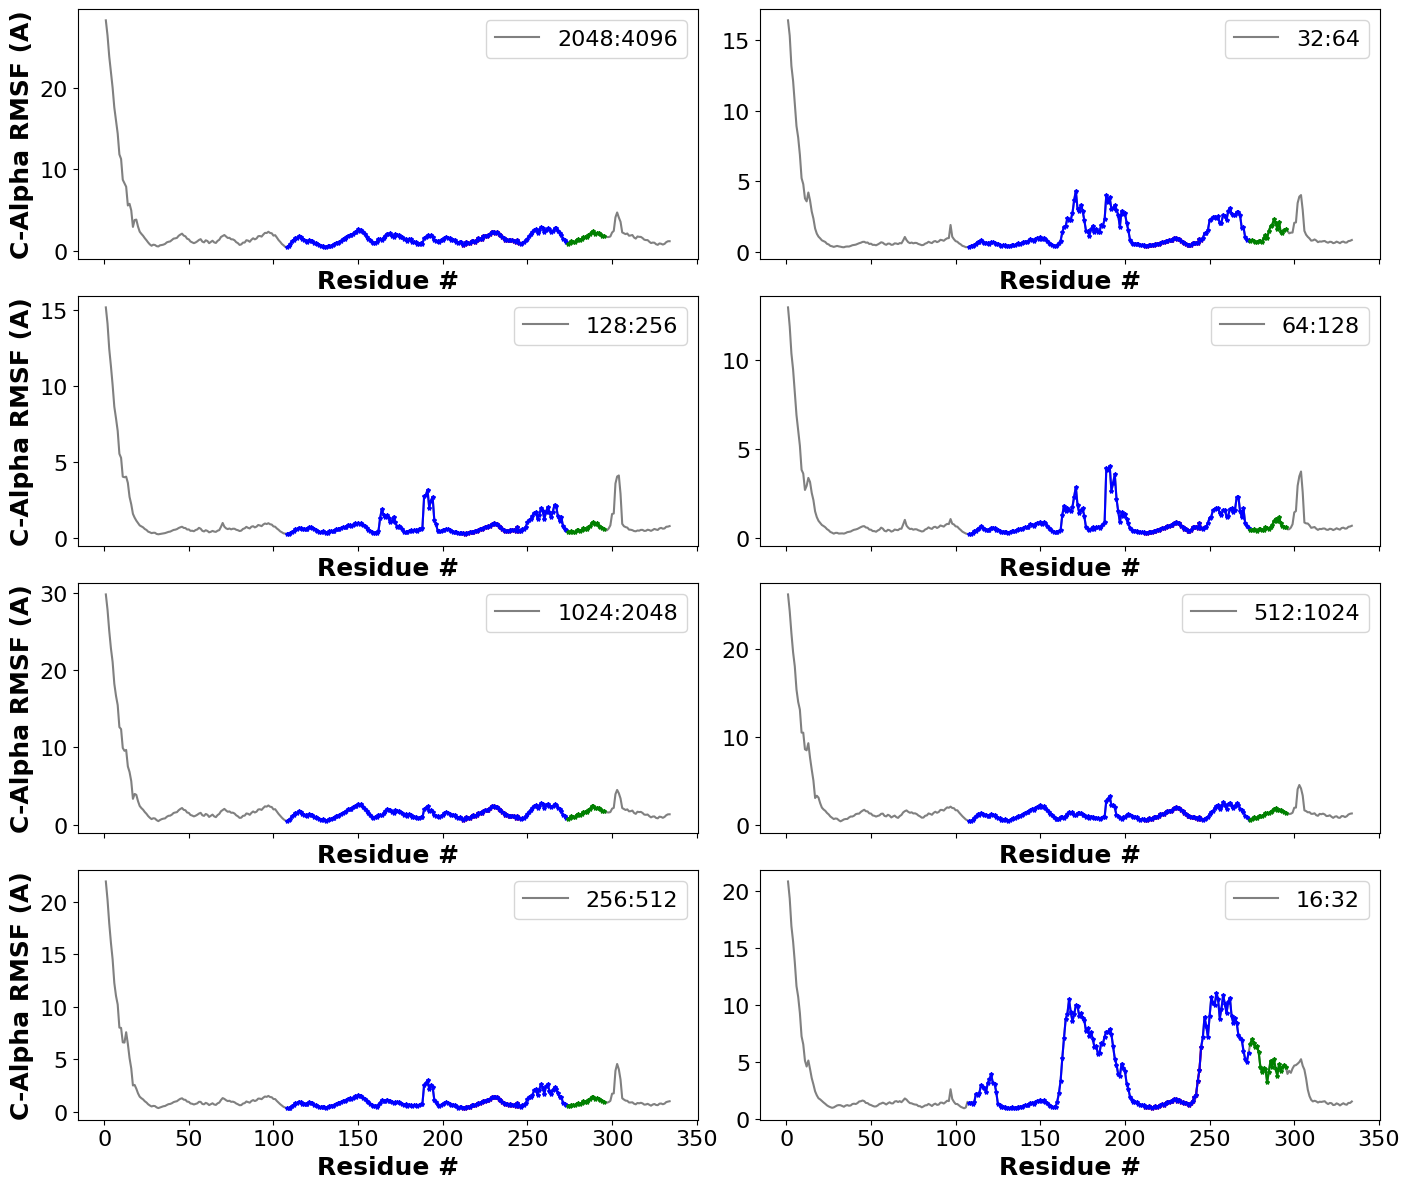

In [7]:
# @title **Plot C-Alpha RMSF after aligning to #1 Ranked Structure + Chosen Ranges**
optimizer_manager.plot_variation_regions()

In [8]:
# @title **Evaluate and Rank RMSD Distributions for Selected Ranges and Prediction Parameters**

# @markdown #### 1. **Assess RMSD Distributions for Each Chosen C-Alpha Region**
# @markdown - **1.1** Utilize the top-ranked prediction (using pLDDT) for RMSD alignment.
# @markdown - **1.2** Standard parameters guide RMSD computation across the 160 predictions in every ensemble.
# @markdown - **1.3** This process is reiterated for every chosen range and for each max_seq:extra_seq pairing.

# @markdown ---

# @markdown ### 2. **Identify Conformational States and Evaluate Subsampling Parameter Ranges**
# @markdown - **2.1** For each residue stretch, ascertain Gaussian kernel densities (KDE) for the RMSD distribution.
# @markdown - **2.2** Apply scikit-learn's _find_peaks_ to spot the distribution modes.
# @markdown - **2.3** From each KDE, pick the two modes with the highest density values.
# @markdown - **2.4** Sequence the chosen modes by their RMSD values.
# @markdown  - **2.4.1** The mode with the minimal RMSD is considered the ground state.
# @markdown  - **2.4.2** The other mode represents the dominant alternate state.
# @markdown - **2.5** A series of checks validate these assumptions.
# @markdown  - **2.5.1** The ground state mode should have greater density than the alternate state mode.
# @markdown  - **2.5.2** There should be a minimum 1A RMSD difference between the modes.
# @markdown  - **2.5.3** The RMSD difference between the modes should not exceed 15A.
# @markdown - **2.6** Datasets failing these checks or with just two modes are excluded from subsequent analysis.
# @markdown - **2.7** The remaining datasets are scored on three metrics.
# @markdown  - **2.7.1** Variance of differences between consecutive in-between mode values, indicating prediction coverage and intermediate state presence.
# @markdown  - **2.7.2** Density difference between modes, reflecting the population disparity of predicted states.
# @markdown  - **2.7.3** Distance between modes, gauging the magnitude of the predicted conformational shift.
# @markdown - **2.8** Scoring techniques are drawn from the subsampling optimization shown in our AF2 ensemble prediction pre-print's Abl1 and GMCSF examples: [Read More](https://arxiv.org/abs/2307.14470)


best_parameters = optimizer_manager.get_best_parameter_set()


Analyzing rmsd of porb_wt prediction, parameters 2048:4096, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 32:64, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 128:256, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 64:128, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 1024:2048, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 512:1024, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 256:512, with selection: resid 211:245 and name CA
Analyzing rmsd of porb_wt prediction, parameters 16:32, with selection: resid 211:245 and name CA
Peak range (211, 245) with Alt1 RMSD of 3.07 A for parameter 2048:4096 accepted 
Peak range (211, 245) with Alt1 RMSD of 1.46 A for parameter 128:256 accepted 
Peak range (211, 245) with Alt1 RMSD of 

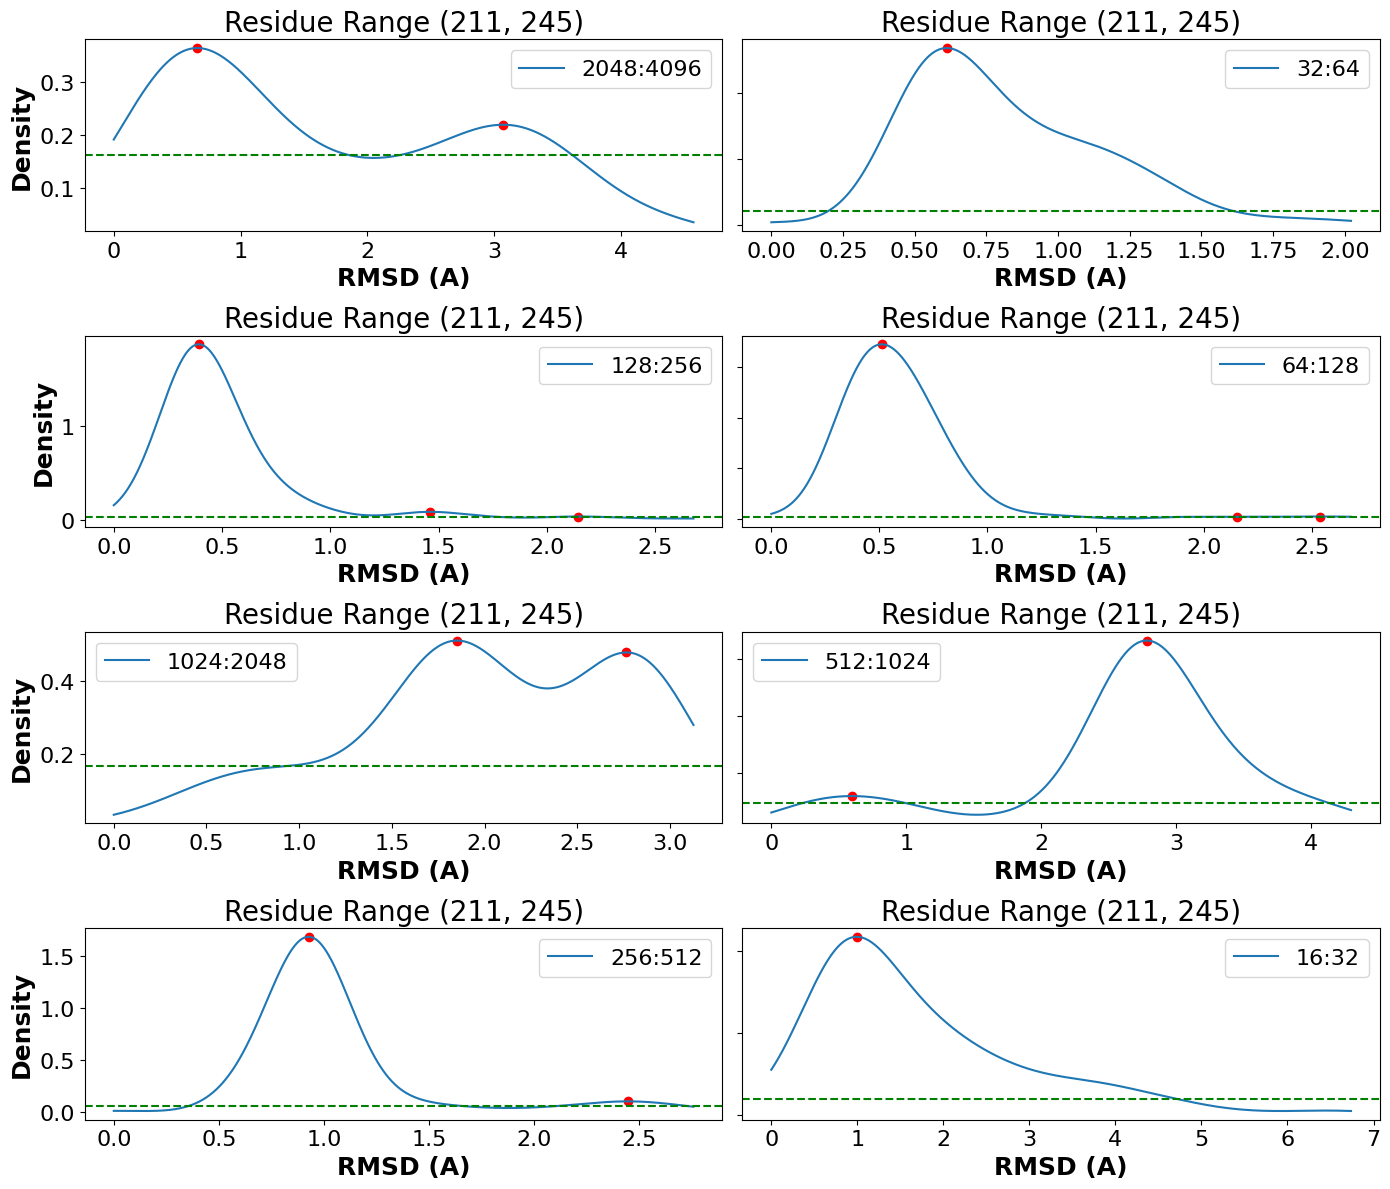

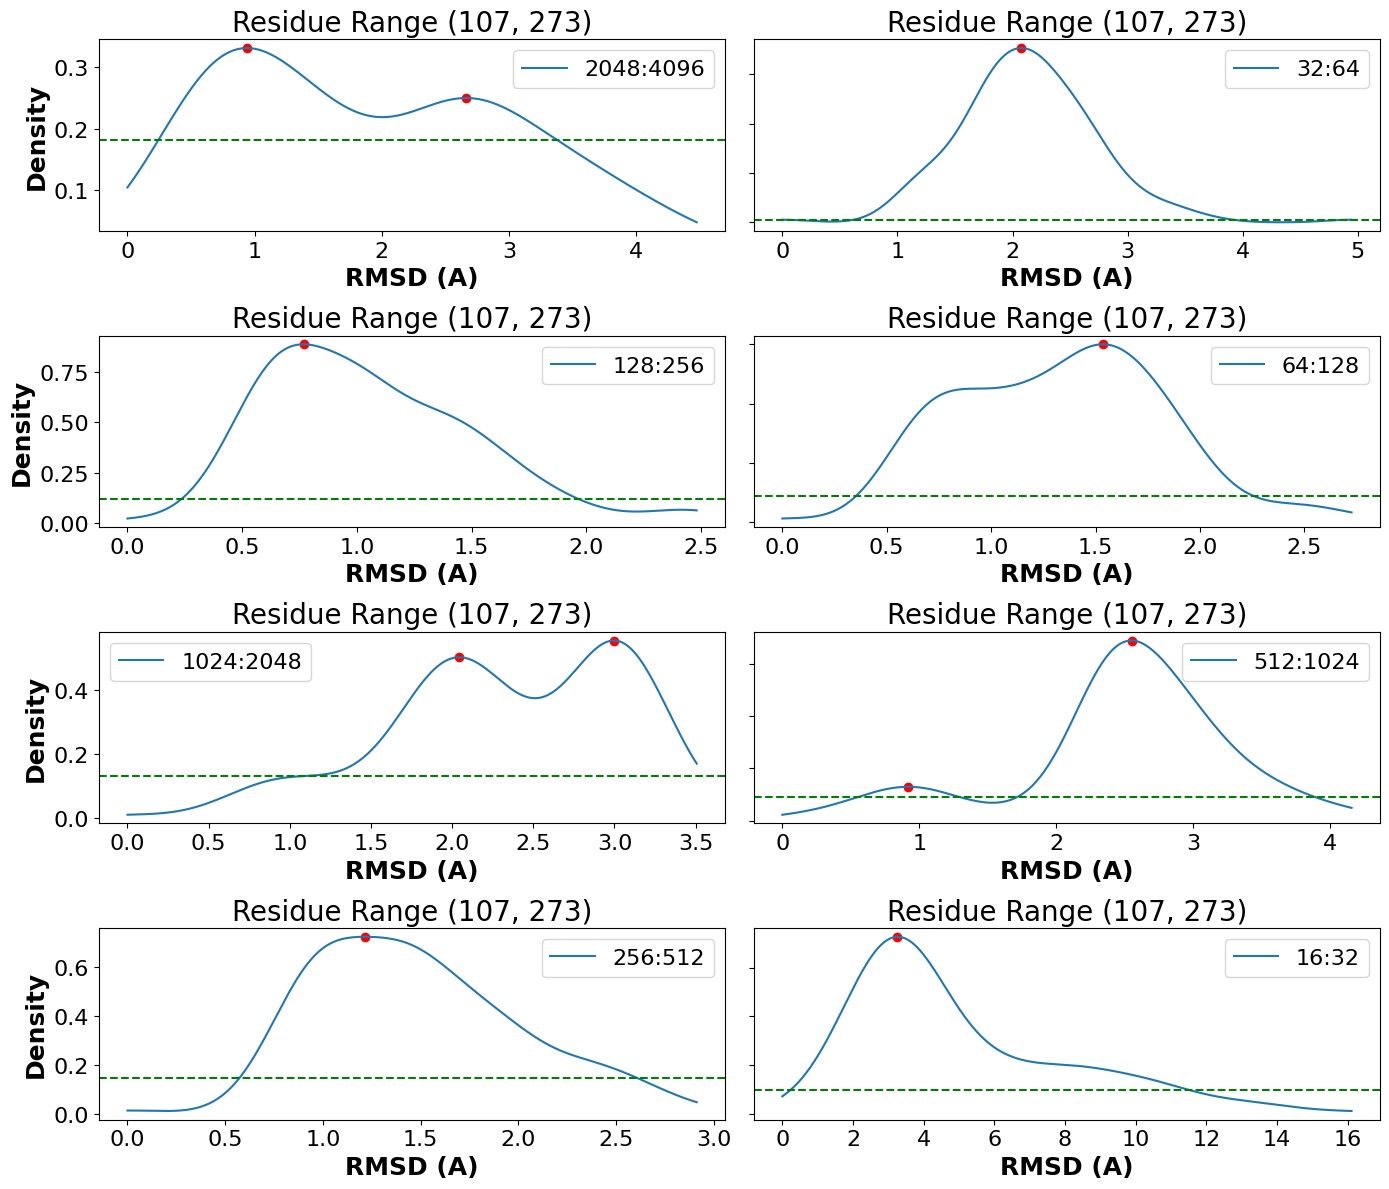

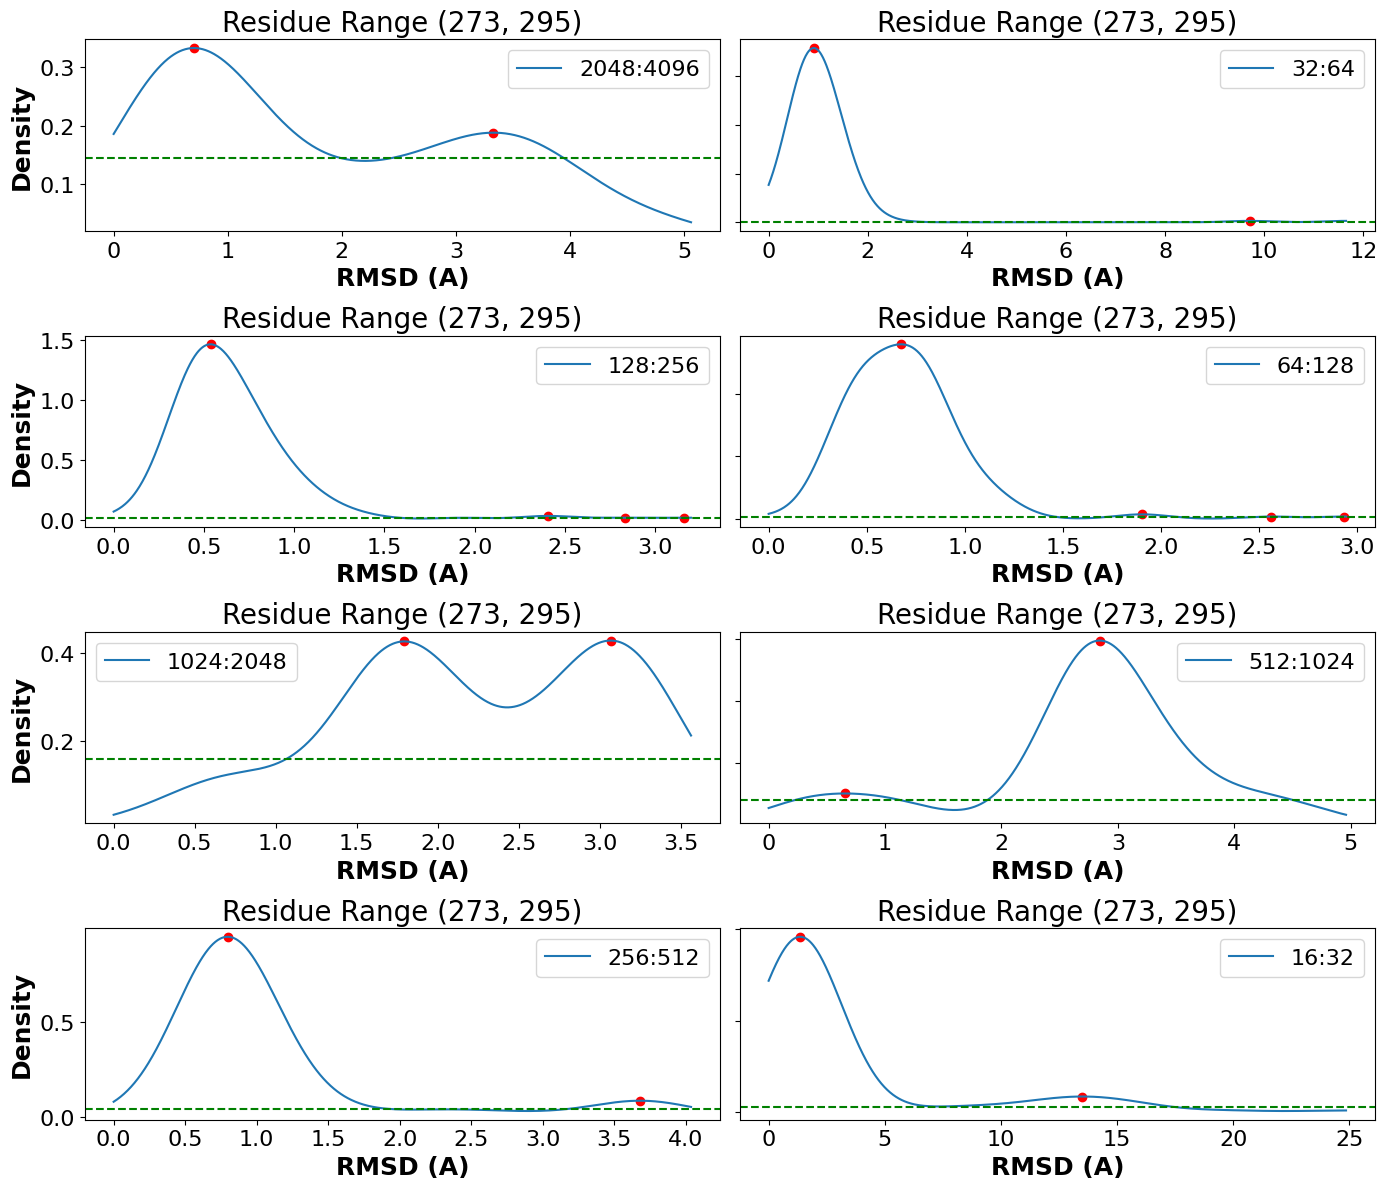

<Figure size 640x480 with 0 Axes>

In [9]:
# @title **Plot KDEs with modes for each selected range for each max_seq:extra_seq parameter range**
optimizer_manager.plot_parameter_set()

Getting representative structures for system porb_wt.
Analyzing rmsd_ref of porb_wt prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 32:64, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 64:128, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 128:256, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 256:512, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 512:1024, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 1024:2048, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 2048:4096, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_wt prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rm

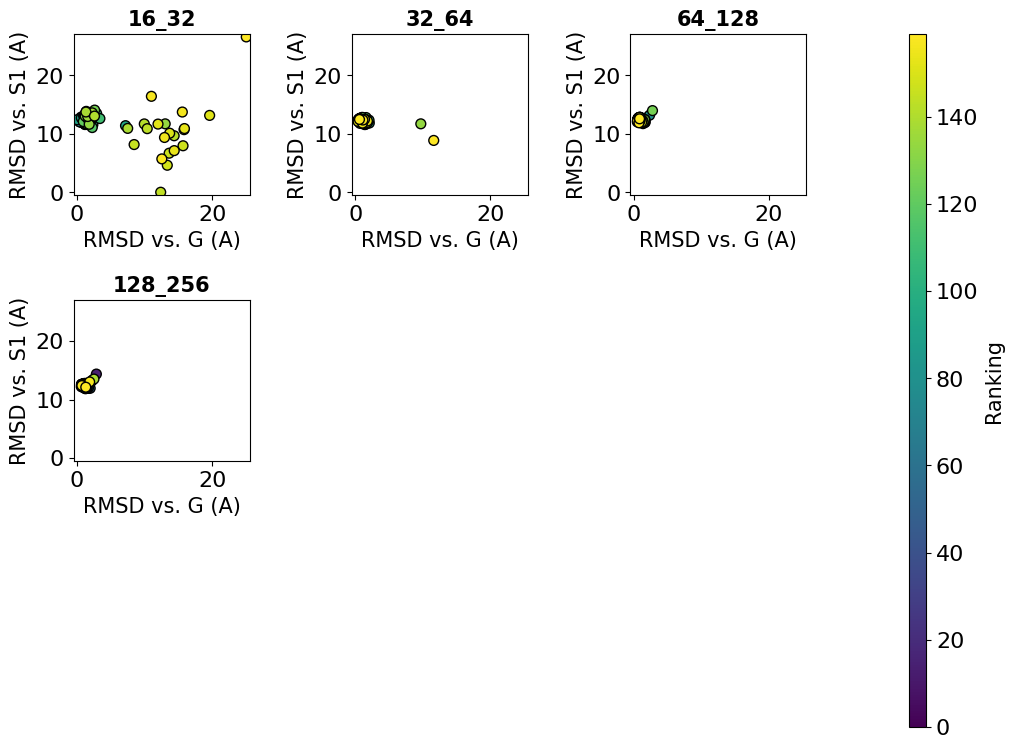

In [10]:
# @title **Identify representative structures for each selected state from the top ranked prediction**
# @markdown Plots 2D C-Alpha RMSD distribution vs. either selected representative state for each prediction
get_representative_structures(config.SYSTEM_NAME, subsampling_pairs)

In [11]:
# @title **Measure the differences in relative state populations for each mutant ensemble**
# @markdown ##### 1. Repeat state detection for each mutant set predicted with the optimized parameter range.
# @markdown ##### 2. Measure the differences in the population (density) of the ground and alt1 state pairs for each mutant vs. the wild-type values.
# @markdown ##### 3. Return % changes and accuracy report if effects are known.
tester = MutantTester(config.SYSTEM_NAME)
tester.test_mutants()

Testing mutants for system porb_wt.
Analyzing rmsd of porb_e318n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd of porb_s312e prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd of porb_d122n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Loading from disk rmsd of porb_wt prediction, parameters 16:32, with selection: resid 273:295 and name CA


({'ground_pop right': {'porb_e318n': 'Right by 5.535039411225909%',
   'porb_s312e': 'Right by 8.131440592562061%',
   'porb_d122n': 'Right by 4.845208045321748%'},
  'ground_pop wrong': {},
  'alt1_pop right': {'porb_e318n': 'Right by -0.2869397863155262%',
   'porb_s312e': 'Right by -0.11089223005502184%',
   'porb_d122n': 'Right by -0.19521487966431827%'},
  'alt1_pop wrong': {}},
 100.0,
 100.0)

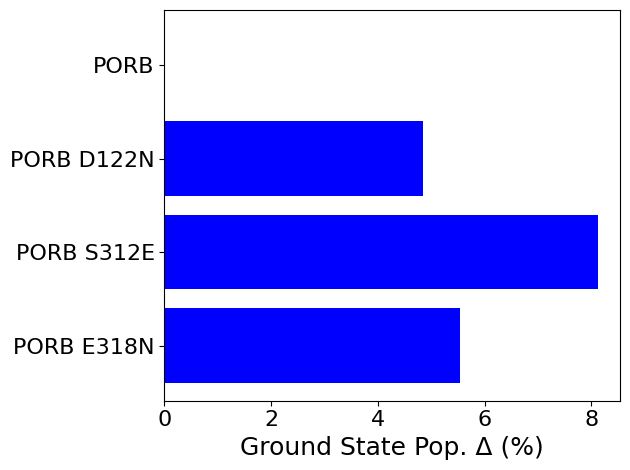

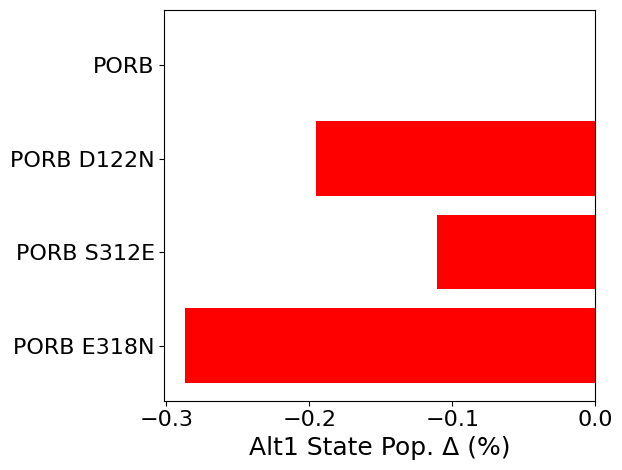

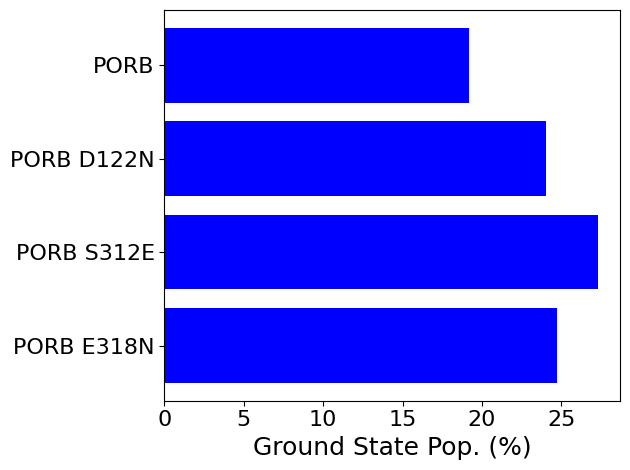

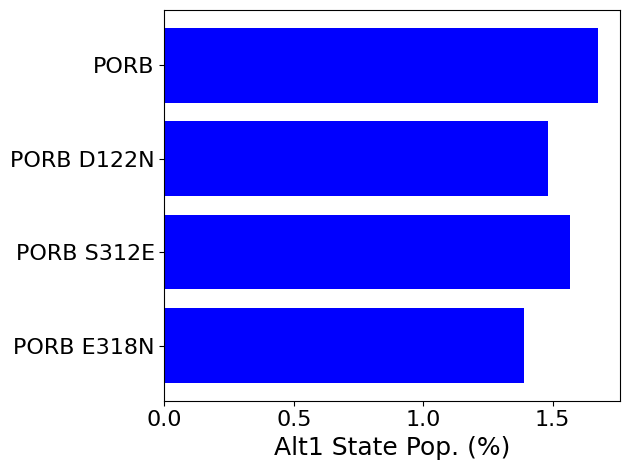

<Figure size 640x480 with 0 Axes>

In [12]:
# @title **Plot calculated differences for each mutant as well as absolute values**
tester.plot_results()

Analyzing rmsd_ref of porb_e318n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_s312e prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_d122n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Loading from disk rmsd_ref of porb_wt prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_e318n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_s312e prediction, parameters 16:32, with selection: resid 273:295 and name CA
Analyzing rmsd_ref of porb_d122n prediction, parameters 16:32, with selection: resid 273:295 and name CA
Loading from disk rmsd_ref of porb_wt prediction, parameters 16:32, with selection: resid 273:295 and name CA


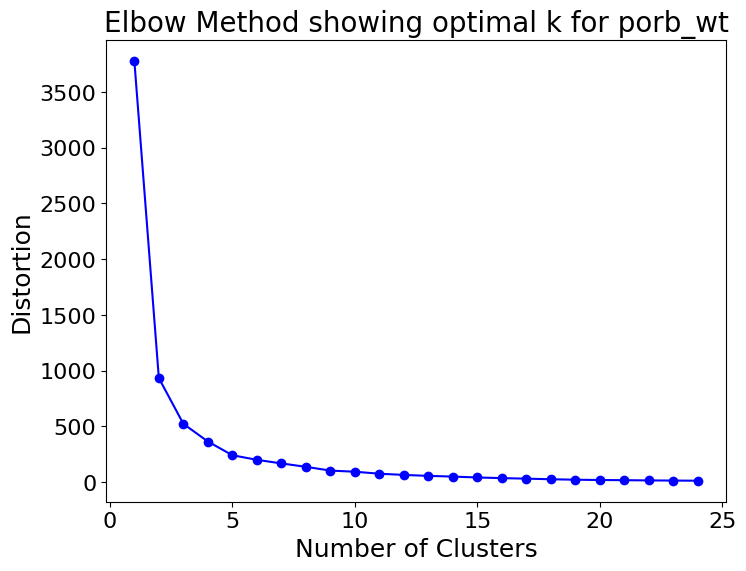

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [13]:
# @title **Cluster 2D RMSD distribution (vs. ground and vs. alt1) for the wild-type prediction**
mut_manager = MutationClusterManager(config.SYSTEM_NAME)
mut_manager.build_wt_model()

In [14]:
# @title **Apply wild-type clustering model to mutants and calculate differences in cluster populations**
mut_manager.measure_effects()

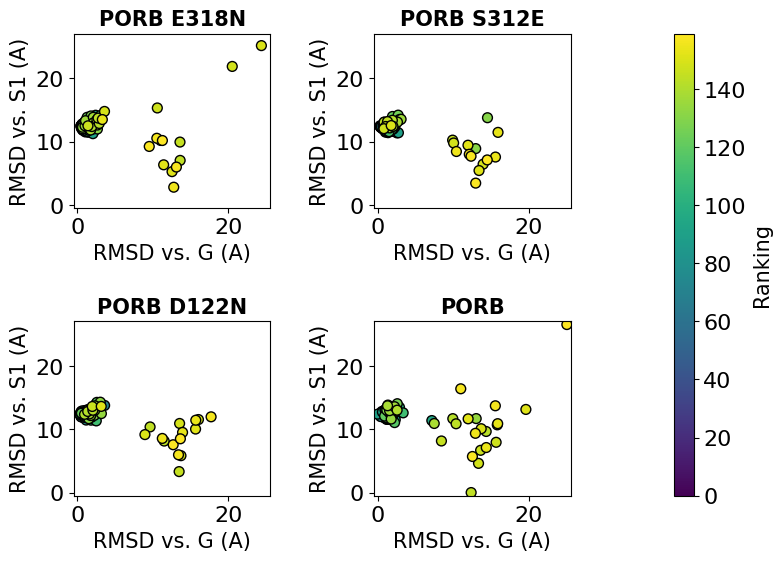

In [15]:
# @title **Plot 2D RMSD distribution for all analyzed variants, before clustering**
mut_manager.plot_mutant_state_finder_results()

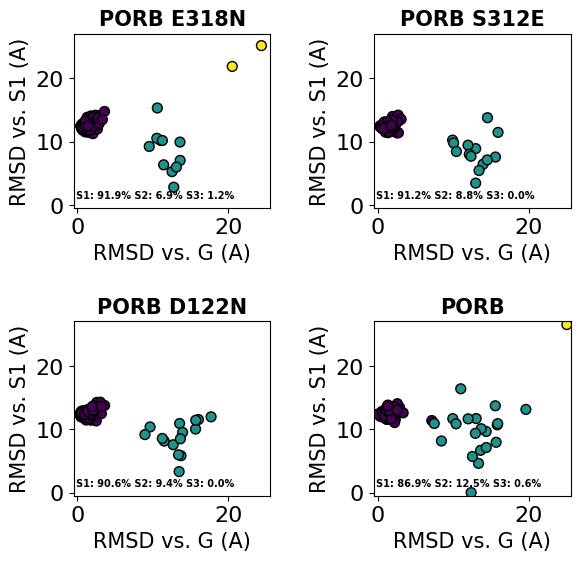

In [16]:
# @title **Plot 2D RMSD distribution for all analyzed variants, after clustering**
mut_manager.plot_cluster_results()

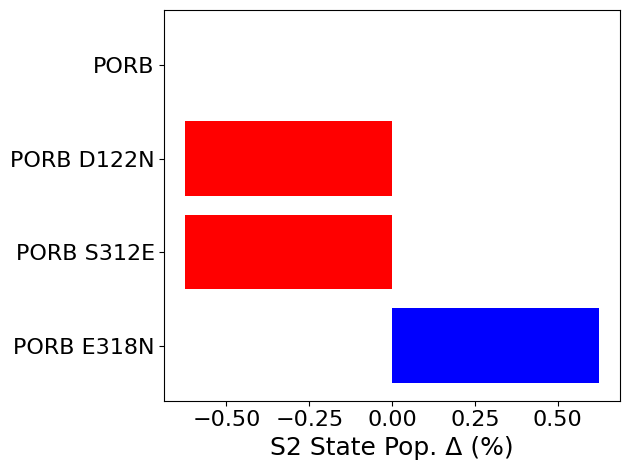

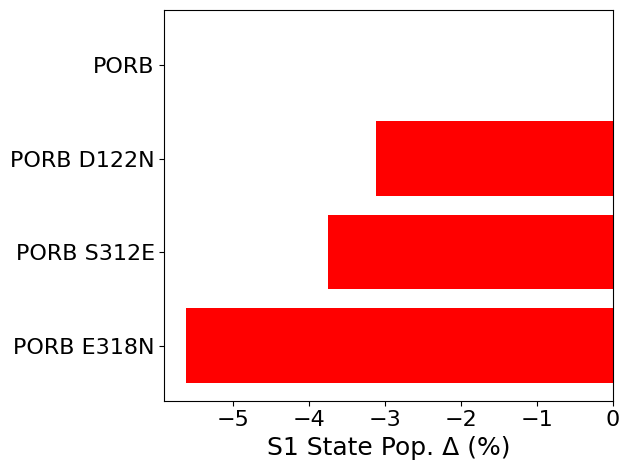

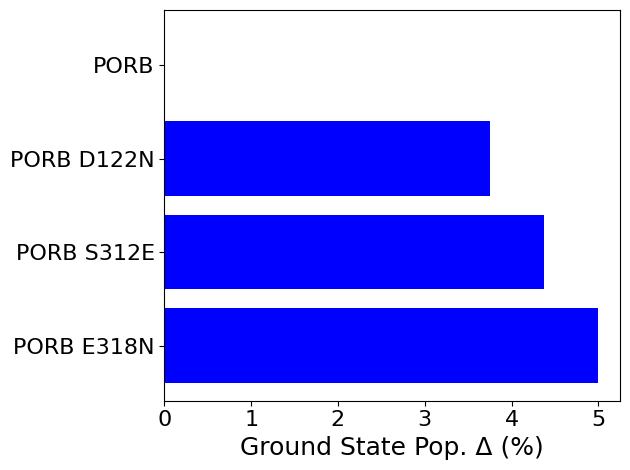

<Figure size 640x480 with 0 Axes>

In [17]:
# @title **Plot differences in cluster populations for each variant tested**
mut_manager.plot_clustering_diffs()